In [1]:
import tensorflow as tf 
import numpy as np
import os
import time
import functools
from tqdm import tqdm
from IPython import display as dis

In [2]:
# !pip install mitdeeplearning
import mitdeeplearning as mdl

In [3]:
songs = mdl.lab1.load_training_data()
songs_joined = "\n\n".join(songs) 
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

Found 816 songs in text
There are 83 unique characters in the dataset


In [4]:
idx2char = np.array(vocab)
char2idx = {u:i for i, u in enumerate(idx2char)}

In [5]:
def vectorize_song(song):
    vec = []
    for i in tqdm(song): 
    vec = np.append(vec , char2idx[i])
    return np.array(vec)

vectorized_songs = vectorize_song(songs_joined)

100%|██████████| 200425/200425 [00:11<00:00, 17423.74it/s]


In [6]:
def get_batch(vectorized_songs, seq_length, batch_size):
    n = vectorized_songs.shape[0] - 1
    idx = np.random.choice(n-seq_length, batch_size)

    input_batch = [vectorized_songs[i: i+seq_length] for i in idx]
    output_batch = [vectorized_songs[i+1: i+seq_length+1] for i in idx]

    # x_batch, y_batch provide the true inputs and targets for network training
    x_batch = np.reshape(input_batch, [batch_size, seq_length],)
    y_batch = np.reshape(output_batch, [batch_size, seq_length])
    return x_batch.astype(np.int32), y_batch.astype(np.int32)

In [7]:
# use this trick for find lr range
# and do smaller range for next epoch
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

class LRFinderCallback(Callback):
    def __init__(self, min_lr, max_lr, mom=0.9, batches_lr_update=3):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.mom = mom
        self.batches_lr_update = batches_lr_update
        self.stop_multiplier = -20*self.mom/3 + 10 # 4 if mom=0.9  10 if mom=0
                
    def on_train_begin(self, logs={}):
        p = self.params
        n_iterations = p['steps']*p['epochs']    
        self.learning_rates = np.geomspace(self.min_lr, self.max_lr, num=n_iterations//self.batches_lr_update+1)
        self.losses=[]
        self.iteration=0
        self.best_loss=0
        
    
    def on_batch_end(self, batch, logs={}):
        loss = logs.get('loss')
        if self.iteration!=0: # Make loss smoother using momentum
            loss = self.losses[-1]*self.mom+loss*(1-self.mom)
        
        if self.iteration==0 or loss < self.best_loss: 
                self.best_loss = loss
                
        if self.iteration%self.batches_lr_update==0: # Evaluate each lr over 5 epochs
            lr = self.learning_rates[self.iteration//self.batches_lr_update]            
            self.model.optimizer.lr = lr
            self.losses.append(loss)            

        if loss > self.best_loss*self.stop_multiplier: # Stop criteria
            self.model.stop_training = True
                
        self.iteration += 1
    
    def on_train_end(self, logs=None):
        plt.figure(figsize=(12, 6))
        plt.plot(self.learning_rates[:len(self.losses)], self.losses)
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale('log')
        plt.show()

In [8]:
def GRU(rnn_units):
  return tf.keras.layers.GRU(
    rnn_units,
    dropout=.3,
    return_sequences=True, # Many2Many 
    stateful=True) # show detail in below
    # ----------------------> dataset
    # [-----]>[-----]>[-----] batches
    # in train time our batches aren't Sequential so it isn't different
    # in test time it's necessary for create new sample(A_state -> B_state)

class GRUResBlock(tf.keras.Model):
    def __init__(self, rnn_units):
        super().__init__()
        self.gru1 = GRU(rnn_units)
        self.gru2 = GRU(rnn_units)

    def call(self, x):
        x = self.gru1(x)
        return x+self.gru2(x)

In [9]:
class Learner(tf.keras.Model):
    def train_step(self, data):
        x, y = get_batch(vectorized_songs, 250, 32)
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(tf.convert_to_tensor(y), y_pred) # in compiled loss (tensor, tensor)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.compiled_metrics.update_state(tf.convert_to_tensor(y), y_pred)
        return {m.name: m.result() for m in self.metrics}

    
def rrn_model(rnn_unit, batch_size):
    return tf.keras.Sequential([
                tf.keras.layers.Embedding(len(vocab), 256, batch_input_shape=[batch_size, None]),
                GRUResBlock(rnn_unit),
                tf.keras.layers.Dense(units=len(vocab))])
    
model = rrn_model(rnn_unit=512, batch_size=32) 
    
learner = Learner(model.inputs, model.outputs)
loss_fn = lambda y, yp: tf.keras.losses.sparse_categorical_crossentropy(y, yp, from_logits=True)
learner.compile(tf.keras.optimizers.Adam(3e-3), loss=loss_fn, metrics=['accuracy'])
learner.summary()

Model: "learner"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_input (InputLayer) [(32, None)]              0         
_________________________________________________________________
embedding (Embedding)        (32, None, 256)           21248     
_________________________________________________________________
gru_res_block (GRUResBlock)  (32, None, 512)           2758656   
_________________________________________________________________
dense (Dense)                (32, None, 83)            42579     
Total params: 2,822,483
Trainable params: 2,822,483
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2
32/32 [==============================] - 87s 3s/step - loss: 4.0386 - accuracy: 0.1591
Epoch 2/2
32/32 [==============================] - 84s 3s/step - loss: nan - accuracy: 0.1600


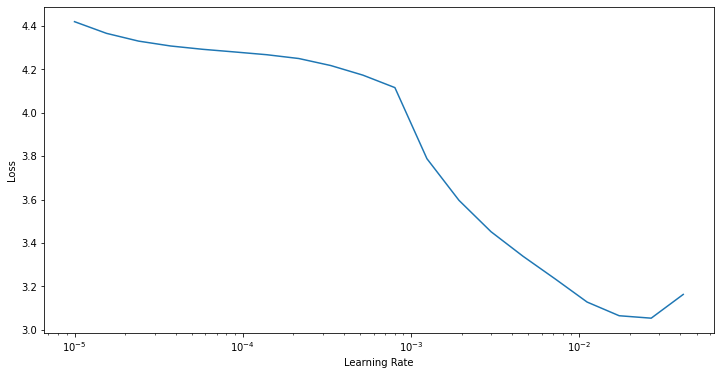

In [10]:
iters = [0]*1000
lr_finder = LRFinderCallback(min_lr=1e-5, max_lr=1e-1, batches_lr_update=3, mom=.5)
learner.fit(iters, iters, batch_size=32, epochs=2, callbacks=[lr_finder])

In [10]:
iters = [0]*1000 
learner.fit(iters, iters, batch_size=32, epochs=10)

Epoch 1/10
32/32 [==============================] - 90s 3s/step - loss: 3.3396 - accuracy: 0.1805
Epoch 2/10
32/32 [==============================] - 94s 3s/step - loss: 1.7223 - accuracy: 0.4690
Epoch 3/10
32/32 [==============================] - 92s 3s/step - loss: 0.9821 - accuracy: 0.6929
Epoch 4/10
32/32 [==============================] - 90s 3s/step - loss: 0.3772 - accuracy: 0.9120
Epoch 5/10
32/32 [==============================] - 90s 3s/step - loss: 0.1046 - accuracy: 0.9849
Epoch 6/10
32/32 [==============================] - 90s 3s/step - loss: 0.0388 - accuracy: 0.9960
Epoch 7/10
32/32 [==============================] - 99s 3s/step - loss: 0.0184 - accuracy: 0.9991
Epoch 8/10
32/32 [==============================] - 98s 3s/step - loss: 0.0109 - accuracy: 0.9996
Epoch 9/10
32/32 [==============================] - 98s 3s/step - loss: 0.0083 - accuracy: 0.9996
Epoch 10/10
32/32 [==============================] - 98s 3s/step - loss: 0.0056 - accuracy: 0.9998


In [11]:
model.save_weights('tmp.h5')
# recreate model with batch size 1 for create new sample
model = rrn_model(rnn_unit=512, batch_size=1)  
model.load_weights('tmp.h5')

In [15]:
def generate_text(model, start_string, generation_length=1000):
    input_eval = [char2idx[s] for s in start_string] # TODO
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []
    tqdm._instances.clear()

    for i in tqdm(range(generation_length)):
        predictions = model(input_eval, training=False)
        predictions = tf.squeeze(predictions, 0)
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx2char[predicted_id]) # TODO 

    return (start_string + ''.join(text_generated))

generated_text = generate_text(model, start_string='X', generation_length=1000)

100%|██████████| 1000/1000 [00:11<00:00, 86.47it/s]


In [13]:
#!apt-get install abcmidi timidity > /dev/null 2>&1 # for play waveform in notebook

In [16]:
generated_songs = mdl.lab1.extract_song_snippet(generated_text)
for i, song in enumerate(generated_songs): 
  waveform = mdl.lab1.play_song(song) 
  if waveform:
    print("Generated song", i+1)
#     dis.display(waveform) install abcmidi and run this

Found 5 songs in text
